In [28]:
import yaml
import glob

import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader
import pytorch_lightning
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from models.ghostnet import GhostNet
from models.convolutional import CNN1D
import utils.dataset
from utils.dataset import ESC50, UrbanSound8K, AudioSet

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import librosa
import torchaudio


# Latent Space

In [29]:
class LatentSpaceCNN1D(CNN1D):
    def __init__(self, learning_rate=1e-3, log_path='./', patience=20):
        super().__init__(learning_rate, log_path, patience)

    def forward(self, x):
        x = self.conv1d(x)
        logits = self.linear(x)
        return torch.flatten(x, 1)

class LatentSpaceGhostNet(GhostNet):
    def __init__(self, cfgs,  learning_rate, log_path, patience, num_classes=2, width=1.0, dropout=0.2):
        super().__init__(cfgs,  learning_rate, log_path, patience, num_classes, width, dropout)
    
    def forward(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = self.conv_head(x)
        x = self.act2(x)
        x = x.reshape(-1, 512)
        if self.dropout > 0.:
            x = F.dropout(x, p=self.dropout, training=self.training)
        return torch.flatten(x, 1)

In [30]:
class GradCAMGhostNet(GhostNet):
    def __init__(self, cfgs,  learning_rate, log_path, patience, num_classes=2, width=1.0, dropout=0.2):
        super().__init__(cfgs,  learning_rate, log_path, patience, num_classes, width, dropout)

        # placeholder for the gradients
        self.gradients = None
        
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def features_conv(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.blocks(x)
        return x

    def forward(self, x):
        x = self.features_conv(x)
        # register the hook
        h = x.register_hook(self.activations_hook)
        x = self.global_pool(x)
        x = self.conv_head(x)
        x = self.act2(x)
        x = x.reshape(-1, 512)
        if self.dropout > 0.:
            x = F.dropout(x, p=self.dropout, training=self.training)
        logits = self.classifier(x)
        return logits
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [31]:
def load_model(path, config, fold):
    model_path = glob.glob(f"{path}/{config['datasets']['main']}-{fold}/trained_models/*.ckpt")[0]
    if config['model']['type'] == 'cnn1d':
        return LatentSpaceCNN1D.load_from_checkpoint(checkpoint_path=model_path,
                                                        learning_rate=config['learning_rate'],
                                                        log_path=path,
                                                        patience=int(config['epochs'] / 10))
    elif config['model']['type'] == 'ghostnet':
        return LatentSpaceGhostNet.load_from_checkpoint(checkpoint_path=model_path,
                                                                cfgs=config['model']['ghostnet']['stages'],
                                                                width=config['model']['ghostnet']['width'],
                                                                learning_rate=config['learning_rate'],
                                                                log_path=path,
                                                                patience=int(config['epochs'] / 10))

In [32]:
def load_dataloader(path, config, fold):
    transforms = None
    if config['model']['type'] == 'ghostnet':
        transforms = [torchaudio.transforms.MelSpectrogram(sample_rate=config['target_sr'],
                                                                f_min=0,
                                                                n_fft=config['transforms']['mel_spectrogram']['n_fft'],
                                                                win_length=config['transforms']['mel_spectrogram']['n_fft'],
                                                                hop_length=config['transforms']['mel_spectrogram']['hop_length'],
                                                                center=config['transforms']['mel_spectrogram']['center'],
                                                                normalized=config['transforms']['mel_spectrogram']['normalized'],
                                                                mel_scale="slaney",
                                                                n_mels=config['transforms']['mel_spectrogram']['n_mels'],
                                                                power=config['transforms']['mel_spectrogram']['power']),
                            torchaudio.transforms.AmplitudeToDB(top_db=80.0)]
    if config['datasets']['main'] == 'esc50':
        dataset = ESC50(train=False,
                annotations_file=config['datasets']['esc50']['annotations_file'],
                audio_dir=config['datasets']['esc50']['audio_dir'],
                folds=[fold],
                transforms=transforms,
                target_sr=config['target_sr'],
                target_size=config['target_size'],
                model=config['model']['type'],
                mixup=False)
    elif config['datasets']['main'] == 'urbansound8k':
        dataset = UrbanSound8K(train=False,
                annotations_file=config['datasets']['urbansound8k']['annotations_file'],
                audio_dir=config['datasets']['urbansound8k']['audio_dir'],
                folds=[fold],
                transforms=transforms,
                target_sr=config['target_sr'],
                target_size=config['target_size'],
                model=config['model']['type'],
                mixup=False)

    return DataLoader(dataset=dataset, drop_last=True, num_workers=config['workers'], collate_fn=utils.dataset.collate_fn, persistent_workers=True)

In [33]:
def get_features(model, dataloader):
    model.eval()
    features = None
    labels = None

    for batch in tqdm(dataloader, desc='Running the model inference'):
        signal = batch[0].to('cpu')
        label = np.vstack([batch[1]]*len(signal))

        with torch.no_grad():
            output = model(signal)
        current_features= output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features
        if labels is not None:
            labels = np.concatenate((labels, label))
        else:
            labels = label

    return features, labels.argmax(1)

In [34]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42).fit_transform(features)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    for label in [0, 1]:
        indices = [i for i, l in enumerate(labels) if l == label]
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, label=label)
    ax.set_title(title)
    ax.legend(loc='best')
    plt.show()

Running the model inference: 100%|██████████| 400/400 [00:09<00:00, 41.78it/s]


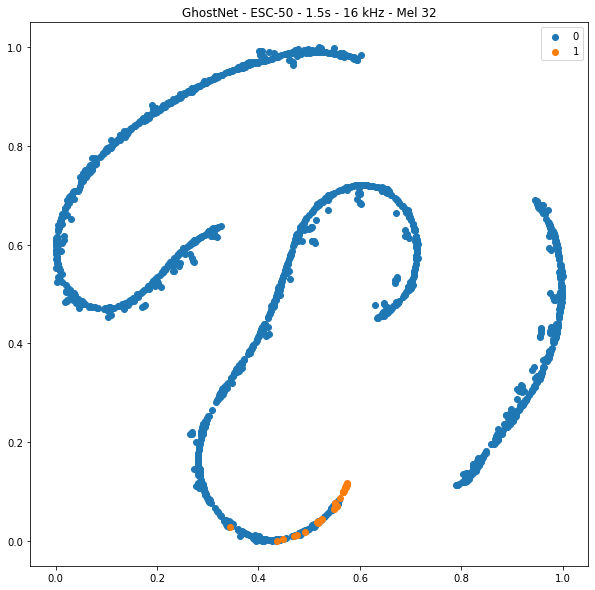

In [35]:
path = "./runs_all/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

pl_model_esc = load_model(path, config, 1)
dataloader_esc = load_dataloader(path, config, 1)

features, labels = get_features(pl_model_esc, dataloader_esc,  )
plot_tsne(features, labels, "GhostNet - ESC-50 - 1.5s - 16 kHz - Mel 32")

Running the model inference: 100%|██████████| 990/990 [00:29<00:00, 33.44it/s]


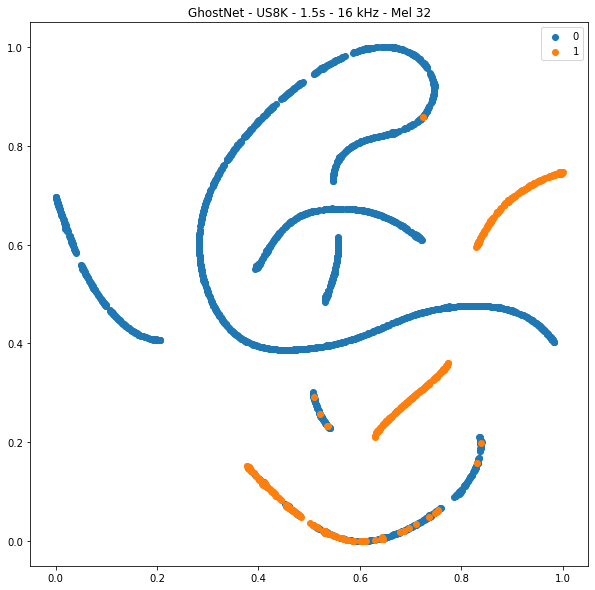

In [36]:
path = "./runs_all/us8k-mel"
fold = 4
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

pl_model_esc = load_model(path, config, fold)
dataloader_esc = load_dataloader(path, config, fold)

features, labels = get_features(pl_model_esc, dataloader_esc)
plot_tsne(features, labels, "GhostNet - US8K - 1.5s - 16 kHz - Mel 32")


Running the model inference: 100%|██████████| 400/400 [00:04<00:00, 88.52it/s] 


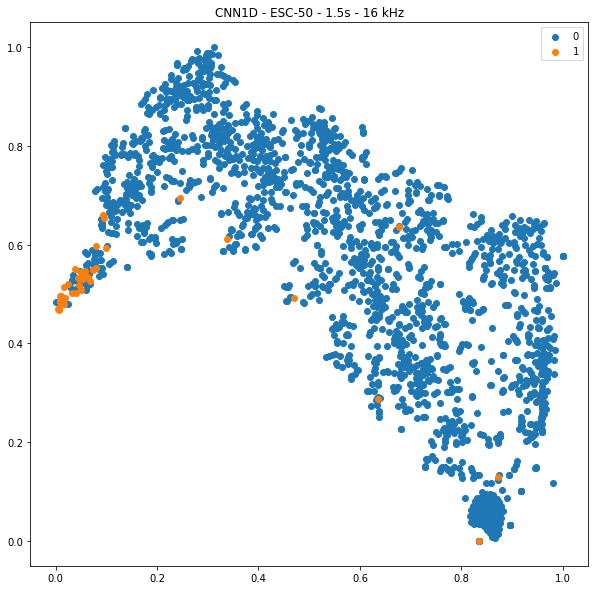

In [37]:
path = "./runs_all/8820-1-conv1d"
fold = 2
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

pl_model_esc = load_model(path, config, fold)
dataloader_esc = load_dataloader(path, config, fold)

features, labels = get_features(pl_model_esc, dataloader_esc)
plot_tsne(features, labels, "CNN1D - ESC-50 - 1.5s - 16 kHz")

In [ ]:
path = "./runs_all/us8k-conv1d"
fold = 8
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

pl_model_esc = load_model(path, config, fold)
dataloader_esc = load_dataloader(path, config, fold)

features, labels = get_features(pl_model_esc, dataloader_esc)
plot_tsne(features, labels, "CNN1D - US8K - 1.5s - 16 kHz")

# Grad-CAM

In [41]:
def load_model(path, config, fold):
    model_path = glob.glob(f"{path}/{config['datasets']['main']}-{fold}/trained_models/*.ckpt")[0]
    if config['model']['type'] == 'ghostnet':
        model = GhostNet.load_from_checkpoint(checkpoint_path=model_path,
                                              cfgs=config['model']['ghostnet']['stages'],
                                              width=config['model']['ghostnet']['width'],
                                              learning_rate=config['learning_rate'],
                                              log_path=path,
                                              patience=int(config['epochs'] / 10))
        return GradCAM(model=model, target_layers=[model.blocks[-4]])

In [43]:
path = "./runs_all/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)
cam_model = load_model(path, config, 2)
dataloader_esc = load_dataloader(path, config, 2)                            

In [60]:
def gram_cam_heatmap(model, dataloader):
    negative = None
    positive = None
    for signal, label in tqdm(dataloader_esc, desc='Running the model inference'):
        res = None
        if torch.argmax(label):
            for i in range(signal.shape[0]):
                signal_ = signal[i].unsqueeze(0)
                grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(1)])
                grayscale_cam = grayscale_cam[0, :]
                if res is None:
                    res = grayscale_cam
                else:
                    res = np.hstack([res, grayscale_cam])
            if positive is None:
                positive = res
            else:
                positive += res

        else:
            for i in range(signal.shape[0]):
                signal_ = signal[i].unsqueeze(0)
                signal_gray = signal_.reshape(32,45).numpy() 
                grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(0)])
                grayscale_cam = grayscale_cam[0, :]
                if res is None:
                    res = grayscale_cam
                else:
                    res = np.hstack([res, grayscale_cam])
            if positive is None:
                negative = res
            else:
                negative += res
    return positive, negative

In [72]:
def plot_heatmap(heatmap, mel_to_freq, n_mels, sr):
    plt.figure(figsize=(20, 10))
    ax = plt.axes()
    plt.imshow(heatmap, origin='lower')

    if mel_to_freq:
        ax.set_yticks([*range(0, heatmap.shape[0], 3)])
        ax.set_yticklabels(librosa.mel_frequencies(n_mels, fmax=sr/2)[::3].astype(int))


In [70]:
pos_heatmap, neg_heatmap = gram_cam_heatmap(cam_model, dataloader_esc)

Running the model inference: 100%|██████████| 400/400 [00:49<00:00,  8.06it/s]


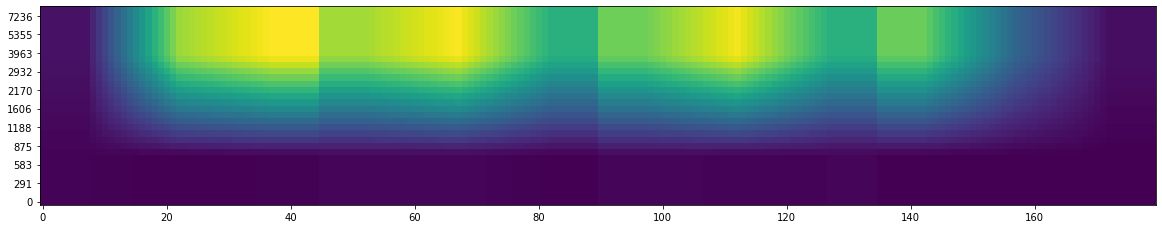

In [73]:
plot_heatmap(pos_heatmap, mel_to_freq=True, n_mels=32, sr=16000)

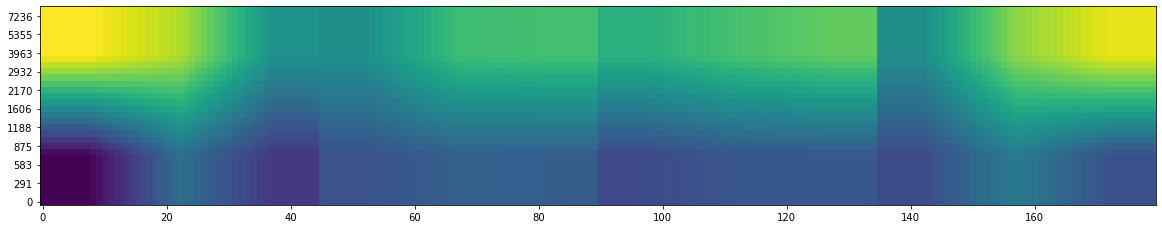

In [74]:
plot_heatmap(neg_heatmap, mel_to_freq=True, n_mels=32, sr=16000)